# Query for pile-up allignments at region "x"

We can query the database to obtain a pile-up of the reads from a given readgroup.

### Initialize the client

As seen in the "1kg.ipynb" example, we take the following steps to create the client object that will be used to obtain the information we desire and query the serever 

In [1]:
import ga4gh.client as client
c = client.HttpClient("http://1kgenomes.ga4gh.org")

### Make reference to the data from the server

We query the server for the dataset, which is the 1k-genomes dataset.
We follow to access the bases of reference. So to access it we first list the reference sets.

In [2]:
dataset = c.searchDatasets().next()
referenceSet = c.searchReferenceSets().next()
references = [r for r in c.searchReferences(referenceSetId = referenceSet.id)]

### Reference chromosome & read group set read groups
We define our contigues sequence with a chromosome reference, and then make a reference array for our read group sets of read groups.

In [3]:
contig ={}
for i in references:
    contig[i.name] = str(i.id)

In [4]:
def readGroupSetByName(name):
    result = None
    for rgs in c.searchReadGroupSets(name=name, datasetId=dataset.id):
        return rgs
    return result
def getReadGroupsByReadGroupSetName(readGroupSetName):
    if None == readGroupSetByName(readGroupSetName):
        return "Sorry, bad request for {}".format(readGroupSetName)
    else:
        return readGroupSetByName(readGroupSetName).read_groups

In [208]:
VarSet = [i for i in c.searchVariantSets(dataset.id)]

release = None
functional = None
VariantRel = []
for variantSet in c.searchVariantSets(datasetId=dataset.id):
    if variantSet.name == "release":
        VariantRel.append(variantSet)
        release = variantSet
    else:
        functional = variantSet

In [209]:
chr1 = filter(lambda x: x.name == "1", references)[0]

In [5]:
def GetReadsForName(Name):
    Name = str(Name)
    if type(getReadGroupsByReadGroupSetName(Name)) == str:
        return getReadGroupsByReadGroupSetName(Name)
    else:
        return [i for i in getReadGroupsByReadGroupSetName(Name)]



### Function to obtain the complement of a negative strand read
This function takes the original sequence if it is in the negative strand and then returns the compliment of the input sequence 

### Pile up function
This function calculates the pile up's for a given region, that is the position being observed. It takes as input the chromosome reference and the readgroups to obtain the needed sequence read. 

In [198]:
def Cigar_Interpreter(Sequence, observe, ReferBase):
    Temp = 0
    BaseCounter = 0
    Variant = ""
    AligSeq = Sequence.aligned_sequence
    InterpArr = list([])
    Iter = 0
    for i in Sequence.alignment.cigar:
        Length = i.operation_length
        if i.Operation.Name(i.operation) == "ALIGNMENT_MATCH":
            InterpArr[len(InterpArr):len(InterpArr)+Length] = AligSeq[Temp:Temp+Length]
            Temp += Length 
            BaseCounter += Length
            
        elif i.Operation.Name(i.operation) == "CLIP_SOFT":
            Temp += Length
            
     
        elif i.Operation.Name(i.operation) == "DELETE":
            int_iter = 0
            for i in range(Length):
                InterpArr[len(InterpArr) : len(InterpArr)+1] = "N"
                BaseCounter += 1
                int_iter += 1
                if BaseCounter == observe:
                    Variant = ReferBase[BaseCounter:BaseCounter+int_iter]
                    return Variant
                
        elif i.Operation.Name(i.operation) == "INSERT":
            for i in range(Length):
                InterpArr[len(InterpArr):len(InterpArr)+1] = AligSeq[Temp : Temp+1]
                Temp += 1
                if (Temp == observe) and (len(InterpArr) >= Temp+Length+1):
                    Variant = "".join(InterpArr[Temp:Temp+Length+1])
                    return Variant
            
        Iter += 1
    if (Temp >= observe) and (len(Sequence.alignment.cigar) == Iter) :
            return InterpArr[observe]
    else: 
        return "N"    
    
    
  

In [199]:
def pileUp(contig, position, rgset):
    alleles = []
    rgset = GetReadsForName(rgset)
    
    if type(rgset) != str:
        for i in rgset:
            for sequence in c.searchReads(readGroupIds=[i.id],start = position, end = position+1, referenceId=contig):
                if sequence.alignment != None:
                    start = sequence.alignment.position.position
                    observe = position-start
                    end = start+len(sequence.aligned_sequence)
                    star = sequence.alignment.position.position
                    if len(sequence.alignment.cigar) > 1:
                        allele = Cigar_Interpreter(sequence, observe,c.listReferenceBases(chr1.id, start=star, end= end) )
                        
                    else:
                        allele = sequence.aligned_sequence[observe]
                    alleles.append({"allele": str(allele), "readGroupId":i.id})
        return Calc_Freq(alleles)
    
    else:
        return rgset

### Function to calculate occurrence frequency
The frequency is obtain from the occurence of alleles in the observed position. And our function returns an array of occurances for a given instance as well as the overall frequency. 

In [234]:
def Calc_Freq(Test):
    tot = len(Test)
    AutCalc = {}
    Arr = []
    for i in range(tot):
        if AutCalc.has_key(Test[i]["allele"]) == False and (Test[i]['allele'] != "N"):
            AutCalc.setdefault(Test[i]["allele"], 1)
            Arr.append(Test[i]['allele'])
        else:
            if Test[i]['allele'] == "N":
                tot -= 1
            else:
                AutCalc[Test[i]["allele"]] = float(AutCalc.get(Test[i]["allele"]) + 1)
    Freq = {}
    tot = float(tot)
    for i in Arr:
        Freq.setdefault(i,float(AutCalc.get(i)/tot))
    return Freq

In [222]:
def Variant_Comp(Position, ReadGroupSetName, Chromo):
    RdGrp = GetReadsForName(ReadGroupSetName)
    Chrom = contig.get(Chromo, None) 
    if (Chrom != None) and type(RdGrp != str) :
        base = c.listReferenceBases(Chrom, start = Position, end = Position+1)
        var = pileUp(Chrom, Position, ReadGroupSetName)
        return (str(base), var)
    else:
        if RdGrp == None:
            print"Read Group Set '{}' is not in the API".format(ReadGroupSetName)
        else:
            print"Chromosome '{}' is not in the API".format(Chromo)

In [223]:
Variant_Comp(10176, "NA21144","1")



('A',
 {'A': 0.41025641025641024,
  'AC': 0.05128205128205128,
  'C': 0.5128205128205128,
  'T': 0.02564102564102564})

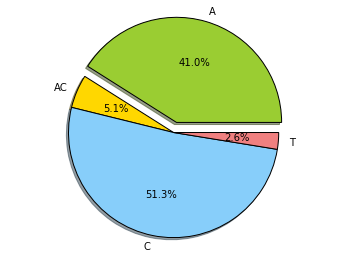

In [239]:
%matplotlib inline
import matplotlib.pyplot as plt
Refer, Freqs = Variant_Comp(10176, "NA21144","1")
labels = Freqs.keys()
sizes = Freqs.values()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
Expl= {}
for i in labels:
    if i == Refer:
        Expl.setdefault(i,0.1)
    else:
        Expl.setdefault(i,0)
explode = Expl.values()

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=0)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

plt.show()

In [78]:
print exampleVariant[0]
print exampleVariant[0].start
print release.id
print chr1.name

Variant({"info": {"EUR_AF": ["0.405600011349"], "SAS_AF": ["0.494899988174"], "AC": ["2130"], "AA": ["|||unknown(NO_COVERAGE)"], "AF": ["0.425318986177"], "AFR_AF": ["0.490900009871"], "AMR_AF": ["0.360199987888"], "AN": ["5008"], "VT": ["INDEL"], "EAS_AF": ["0.336299985647"], "NS": ["2504"], "DP": ["103152"]}, "updated": null, "end": 10177, "calls": [{"info": {}, "genotype": [1, 0], "callSetId": "WyIxa2dlbm9tZXMiLCJ2cyIsInJlbGVhc2UiLCJIRzAwMDk2Il0", "phaseset": "True", "genotypeLikelihood": [], "callSetName": "HG00096"}, {"info": {}, "genotype": [0, 1], "callSetId": "WyIxa2dlbm9tZXMiLCJ2cyIsInJlbGVhc2UiLCJIRzAwMDk3Il0", "phaseset": "True", "genotypeLikelihood": [], "callSetName": "HG00097"}, {"info": {}, "genotype": [0, 1], "callSetId": "WyIxa2dlbm9tZXMiLCJ2cyIsInJlbGVhc2UiLCJIRzAwMDk5Il0", "phaseset": "True", "genotypeLikelihood": [], "callSetName": "HG00099"}, {"info": {}, "genotype": [1, 0], "callSetId": "WyIxa2dlbm9tZXMiLCJ2cyIsInJlbGVhc2UiLCJIRzAwMTAwIl0", "phaseset": "True", "ge

In [210]:
exampleVariant = [j for j in c.searchVariants(variantSetId=release.id, start=10000, end=11000, referenceName=chr1.name)]

AttributeError: 'NoneType' object has no attribute 'id'